# Пример работы с Word2Vec
### Подключаем жизненно необходимые библиотеки

In [ ]:
import multiprocessing
import pandas as pd
import string

import warnings
warnings.filterwarnings("ignore")

print(f'Количество доступных ядер: {multiprocessing.cpu_count()}')

Количество доступных ядер: 2


### Монтируем пространство на диске
Можно скачать файл с данными отсюда - https://disk.yandex.ru/i/p7dh5dqPTpgvsg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Выгружаем датафрейм с репликами из Эпизодов Симпсонов

In [ ]:
path = '/content/drive/MyDrive/data/simpsons_dataset.csv'
df = pd.read_csv(path)
print(f'Размер датафрейма: {df.shape}')
df.head()

Размер датафрейма: (158314, 2)


,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


Обрабатываем пропущенные значения

In [ ]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [ ]:
old_len = df.shape[0]
df = df.dropna().reset_index(drop=True)
new_len = df.shape[0]
print(f'Размер датафрейма после удаления пропусков: {df.shape}')
print(f'Удалили {round(100 * (old_len - new_len) / old_len, 2)}% данных')

Размер датафрейма после удаления пропусков: (131853, 2)
Удалили 16.71% данных


Предобработка текстов

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

stopwords = list(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
def preprocess_text(text):
  tokens = word_tokenize(text)
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  words = [lemmatizer.lemmatize(t.lower()) for t in tokens if
           # удаляем пунктуацию
            (t not in string.punctuation) &
           # удаляем стоп-слова
            (t.lower() not in stopwords) &
           # удаляем числа
            (not t.isdigit()) &
           # удаляем токены по типу 's
            t.isalpha()
          ]
  text = ' '.join(words)

  return text

Небольшая проверочка

In [ ]:
text = "Hey, did you know that the summer break is coming? Amazing right !! It's only 555 more days !!"
preprocess_text(text)

'hey know summer break coming amazing right day'

Предобрабатываем наш датасет

In [ ]:
%%time
df['text'] = df['spoken_words'].apply(lambda x: preprocess_text(x))

CPU times: user 38.6 s, sys: 0 ns, total: 38.6 s
Wall time: 43.8 s


In [ ]:
df.head()

,raw_character_text,spoken_words,text
0,Miss Hoover,"No, actually, it was a little of both. Sometim...",actually little sometimes disease magazine new...
1,Lisa Simpson,Where's Mr. Bergstrom?,bergstrom
2,Miss Hoover,I don't know. Although I'd sure like to talk t...,know although sure like talk touch lesson plan...
3,Lisa Simpson,That life is worth living.,life worth living
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...,poll open end recess case decided put thought ...


In [ ]:
df = df.dropna().drop_duplicates()
df.shape

(126646, 3)

In [ ]:
%%time
df['text'] = df['text'].apply(lambda x: word_tokenize(x))
sentences = list(df.text.values)
print(sentences[2])

['know', 'although', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach']
CPU times: user 13.3 s, sys: 65.2 ms, total: 13.3 s
Wall time: 13.7 s


Обучаем модель

In [ ]:
from gensim.models import Word2Vec

- min_count [int] - пропускает все слова с частотой меньше, чем min_count - (2, 100)

- window [int] - размер окна (на самом деле, половина того окна, про которое мы говорили на лекции) - (2, 10)

- vector_size [int] - размер итоговых векторов - (50, 300)

- alpha [float] - learning rate - (0.01, 0.05)

- min_alpha [float] - минимальный learning rate

- workers [int] - количество параллельно работающих процессов (для ускорения вычислений)

In [ ]:
w2v_model = Word2Vec(
    # sentences,
    min_count=20,
    window=2,
    vector_size=300,
    alpha=0.03,
    min_alpha=0.0007,
    workers=1
)

In [ ]:
# Формируем словарь
w2v_model.build_vocab(sentences, progress_per=10000)

In [ ]:
# Обучаем модель
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(15061327, 19755390)

In [ ]:
# Заранее считаем необходимые нормы для векторов
w2v_model.init_sims(replace=True)

In [ ]:
# Выводим слова, наиболее близкие для слова 'homer'
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.39764314889907837),
 ('abe', 0.35008978843688965),
 ('grampa', 0.29283607006073),
 ('bart', 0.28129926323890686),
 ('dad', 0.2791822552680969),
 ('homie', 0.2543313503265381),
 ('abraham', 0.2508898973464966),
 ('manjula', 0.24701429903507233),
 ('father', 0.24498704075813293),
 ('family', 0.24297502636909485)]

In [ ]:
# Выводим слова, наиболее близкие для слова 'marge'
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.39764314889907837),
 ('abe', 0.3615567982196808),
 ('homie', 0.3255634903907776),
 ('wife', 0.2842337489128113),
 ('lisa', 0.2675529718399048),
 ('mom', 0.267157644033432),
 ('honey', 0.26713863015174866),
 ('well', 0.26193228363990784),
 ('friend', 0.2562215328216553),
 ('husband', 0.24734503030776978)]

In [ ]:
# Можно получить вектор конкретного слова
w2v_model.wv['homer']

array([-3.68769988e-02, -1.27588194e-02, -6.59117922e-02, -3.11804675e-02,
       -3.45859677e-02, -6.58166781e-02, -1.16249286e-02,  2.57932134e-02,
       -8.79899785e-02, -2.64415741e-02, -2.13064011e-02, -8.12479109e-02,
        6.47679344e-02,  9.41037573e-03, -2.75572296e-02, -2.52893139e-02,
       -7.32629597e-02, -1.47270886e-02, -2.38078032e-02,  3.09058353e-02,
       -5.52019700e-02,  1.62897588e-04,  4.45527919e-02,  3.05578634e-02,
        1.03650736e-02, -3.95701863e-02,  8.51156861e-02, -7.22831860e-02,
       -7.64994649e-03, -3.60441729e-02,  3.51095758e-02,  5.90812713e-02,
        8.20636898e-02, -1.92957930e-02, -9.68149602e-02,  5.46132922e-02,
        3.48682627e-02, -7.87881017e-02, -5.00516361e-03, -7.64988065e-02,
       -2.87024323e-02, -9.89771113e-02,  2.69606877e-02, -6.80530490e-03,
       -5.47498204e-02, -7.57537633e-02,  2.72312779e-02, -5.49089387e-02,
        3.75619493e-02,  3.80950384e-02,  1.76577359e-01,  8.09073374e-02,
        1.72003843e-02, -

### Проверим арифметику векторов
'homer' + 'woman' - 'man'

In [ ]:
w2v_model.wv.most_similar(positive=["homer", "woman"], negative=["man"], topn=1)

[('marge', 0.26616382598876953)]

'bart' + 'woman' - 'man'

In [ ]:
w2v_model.wv.most_similar(positive=["bart", "woman"], negative=["man"], topn=1)

[('lisa', 0.26985472440719604)]

### Нарисуем взаимное расположение векторов слов по двум главным компонентам

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    close_words = model.wv.most_similar([word])

    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    reduc = PCA().fit_transform(arrays)

    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

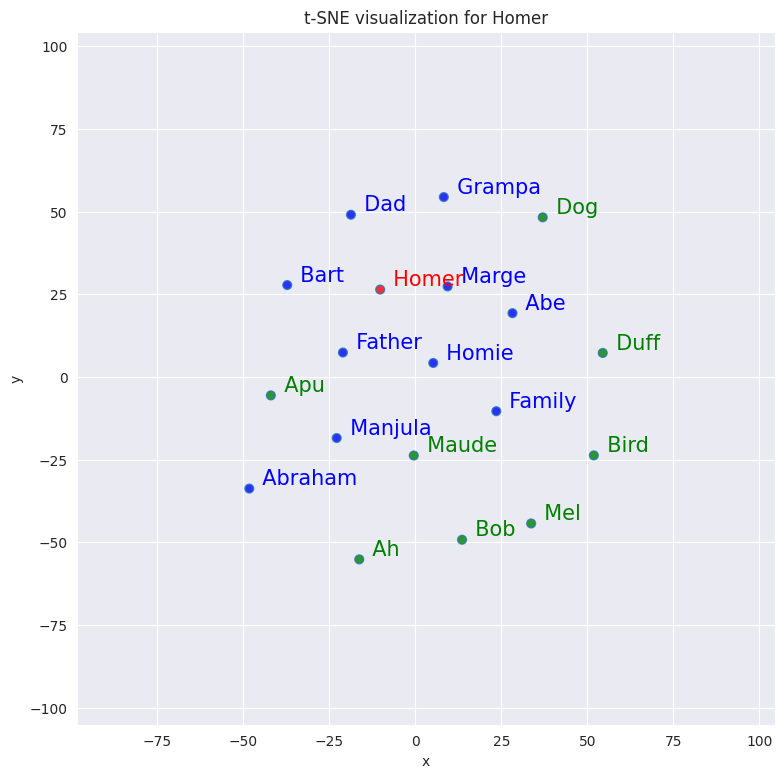

In [ ]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])